In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models
from utils import *
from sklearn.model_selection import train_test_split

In [4]:
defaults.device = torch.device('cuda', 0)

In [6]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_22050_trimmed_tfms'

CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

In [7]:
df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

# validation split; stratified by label
idx = np.arange(len(df))
train_idx, valid_idx = train_test_split(idx, test_size=0.2, stratify=df['label'])
df['valid'] = False
df.loc[df.iloc[valid_idx].index, 'valid'] = True

def tfm_df(df, n_tfms=5):
    dfs = []
    for i in range(n_tfms + 1):
        suffix = '_{:02d}'.format(i)
        new_df = df.copy()
        new_df['fname'] = new_df['fname'] + suffix
        dfs.append(new_df)
    tfm_df = pd.concat(dfs)
    return tfm_df
        
df_tfm = tfm_df(df)
# two files were corrupt when generating transformed files, just remove them from df
df_tfm = df_tfm[~df_tfm['fname'].isin(['255db1a8_05', 'f406520b_01'])]
drop_idx = (df_tfm['valid'] == True) & (~df_tfm['fname'].str.endswith('_00'))
df_final = df_tfm[~drop_idx]
len(df_tfm), df_final['valid'].sum(), (~df_final['valid']).sum()

(56836, 1895, 45466)

In [7]:
n_fft = 512
n_hop = 256
n_mels = 128
sample_rate = 22050
top_db = 50.0
ref = 1.0

bs = 8

trn_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, 
    sample_rate=sample_rate, rand_hop_pct=0.15)

val_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, 
    sample_rate=sample_rate)

tfms = get_transforms(min_len=n_fft)

In [8]:
test_df = pd.read_csv(TEST_CSV)
test_data = AudioItemList.from_df(test_df, path=AUDIO, folder='test', suffix='.wav')

In [10]:
data = (AudioItemList
            .from_df(df_final, path=AUDIO, folder='train', suffix='.wav')
            .split_from_df('valid')
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, length_col=2))
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(45466, 1895, 9400)

In [14]:
data.train_dl.add_tfm(trn_batch_tfms[0])
data.valid_dl.add_tfm(val_batch_tfms[0])
data.test_dl.add_tfm(val_batch_tfms[0])

In [15]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([8, 1, 128, 2475]), torch.Size([8]))

In [19]:
model_name = 'freesound_512_256_128_all_tfms'

learn = create_cnn(data, models.resnet34, metrics=[accuracy, mapk])

In [20]:
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,2.280834,2.359614,0.379420,0.488302
2,1.702626,1.686097,0.574142,0.669393
3,1.598773,1.321633,0.649077,0.729552
4,1.291866,1.306742,0.674406,0.749341
5,1.263599,1.263320,0.678628,0.761126
6,1.058627,1.143759,0.700264,0.776693
7,1.082917,1.198242,0.700792,0.776254
8,1.069354,1.096764,0.713456,0.787863


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


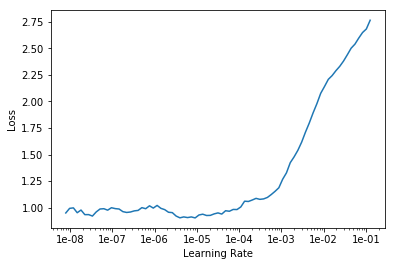

In [21]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [22]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(16, max_lr=slice(1e-5,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy,mapk
1,0.960352,1.044672,0.721900,0.797977
2,0.893189,0.867252,0.775726,0.834125
3,0.633211,0.833134,0.798945,0.853122
4,0.636624,0.916747,0.794195,0.845911
5,0.406259,0.812364,0.820580,0.865787
6,0.300742,0.878688,0.804222,0.854881
7,0.233850,0.834148,0.824274,0.870713
8,0.215196,0.791551,0.831135,0.875726
9,0.299137,0.856228,0.845910,0.881267
10,0.065340,0.798995,0.848021,0.884169


In [25]:
# learn

In [36]:
# save_submission(learn, '512_256_tfms_resnet34_24epochs.csv', tta=False);

In [35]:
# save_submission(learn, '512_256_tfms_resnet34_24epochs_tta.csv', tta=True);

In [31]:
model_name = 'freesound_512_256_128_all_tfms_resnet18'

learn = create_cnn(data, models.resnet18, metrics=[accuracy, mapk])

In [32]:
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,2.222409,2.303039,0.425330,0.538610
2,1.885972,1.737058,0.548285,0.643887
3,1.768370,1.383147,0.607388,0.702463
4,1.477181,1.333308,0.642216,0.730607
5,1.330527,1.226675,0.671768,0.753210
6,1.220509,1.216051,0.692876,0.764732
7,1.163150,1.156279,0.682850,0.764380
8,1.116995,1.164660,0.694459,0.769921


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


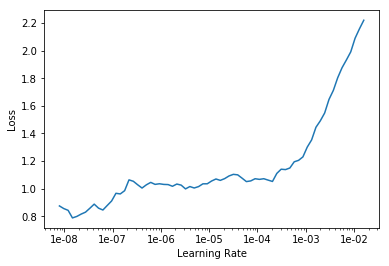

In [33]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [34]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=slice(1e-5,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy,mapk
1,1.030586,1.091864,0.703958,0.782146
2,0.854912,0.978462,0.747757,0.815568
3,0.716422,0.837371,0.793668,0.846438
4,0.460005,0.835150,0.807388,0.856728
5,0.323066,0.828729,0.819525,0.867546
6,0.193718,0.790490,0.829551,0.870185
7,0.154665,0.743597,0.820053,0.865084
8,0.129567,0.756454,0.834828,0.875286


### Fewer features

In [23]:
n_fft = 1024
n_hop = 256
n_mels = 64
sample_rate = 22050
top_db = 60.0
ref = 1.0

bs = 8

trn_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, ref='max',
    sample_rate=sample_rate, rand_hop_pct=0.25)

val_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, ref='max',
    sample_rate=sample_rate)

tfms = get_transforms(min_len=n_fft)

In [24]:
data = (AudioItemList
            .from_df(df_final, path=AUDIO, folder='train', suffix='.wav')
            .split_from_df('valid')
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, length_col=2))

data.train_dl.add_tfm(trn_batch_tfms[0])
data.valid_dl.add_tfm(val_batch_tfms[0])
data.test_dl.add_tfm(val_batch_tfms[0])

len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(45466, 1895, 9400)

In [25]:
model_name = 'freesound_1024_256_64_all_tfms_resnet18'

learn = create_cnn(data, models.resnet18, metrics=[accuracy, mapk]).clip_grad()

In [26]:
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,2.254748,2.097324,0.469657,0.570712
2,1.940092,1.764255,0.546702,0.642392
3,1.652846,1.598277,0.602111,0.693580
4,1.465555,1.400532,0.642744,0.729024
5,1.459671,1.291731,0.681794,0.754881
6,1.210223,1.279531,0.684433,0.759455
7,1.127382,1.275313,0.694987,0.766843
8,1.248340,1.365144,0.669657,0.742481


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


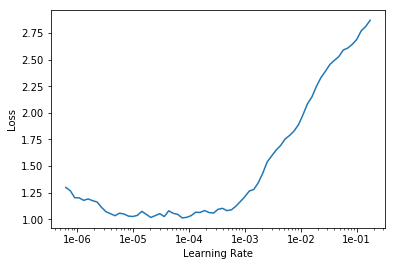

In [20]:
learn.load(model_name + '-stage-2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-5, 1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy,mapk
1,0.986864,1.002506,0.741425,0.806069
2,0.899574,0.923531,0.762533,0.824626
3,0.687431,0.907810,0.789446,0.842305
4,0.578102,0.865496,0.805277,0.855321
5,0.390670,0.799628,0.818470,0.865787
6,0.265895,0.867296,0.815831,0.859983


KeyboardInterrupt: 

In [ ]:
learn.load(model_name + '-stage-3')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-7, 1e-5))
learn.save(model_name + '-stage-4')